In [1]:
import copy
import pdb
import yaml
from typing import List, Union, Dict, Tuple
from PIL import Image
import random
from tqdm import tqdm
import json

import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from data.aokvqa import AOKVQADataset
from data.okvqa import OKVQADataset
from data.vqav2 import VQAv2Dataset
from utils.okvqa_utils import postprocess_ok_vqa_generation, lemmatize
from utils.openai_utils import openai_caller

import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
        format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        level=logging.INFO)

/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'okvqa'
split = 'train'
mode = 'direct_answer'
vlm_name = 'instructblipflant5xl'

VQA_MODEL_TO_DISPLAYNAME = {
    'instructblipflant5xl': 'InstructBLIP',
    'blip2flant5xl': 'BLIP2',
}


DATASET_TO_DISPLAYNAME = {
    'okvqa': 'OK-VQA',
    'aokvqa': 'A-OKVQA',
    'vqav2': 'VQAv2',
}

DATASET_TO_SIZE = {
    'okvqa': 9009,
    'aokvqa': 17056,
    'vqav2': 20000
}
vlm_displayname = VQA_MODEL_TO_DISPLAYNAME[vlm_name]
dataset_displayname = DATASET_TO_DISPLAYNAME[dataset_name]
dataset_size = DATASET_TO_SIZE[dataset_name]

if dataset_name == 'aokvqa':
    if mode == 'direct_answer':
        dataset = AOKVQADataset(split)
    else:
        dataset = AOKVQADataset(split, type='mc')
elif dataset_name == 'okvqa':
    dataset = OKVQADataset(split)
elif dataset_name == 'vqav2':
    dataset = VQAv2Dataset(split)



02/12/2024 15:45:03 - INFO - data.okvqa - Loaded OKVQA train dataset with 9009 examples!
02/12/2024 15:45:03 - WARNING - data.okvqa - Vision/text processors not set!


In [3]:
directvqa_rollouts = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/directvqa/{dataset_name}_{mode}/train_outputs/{vlm_name}_direct_vqa-1rollouts-{dataset_size}examples.json'))
eval_size = 5000
directvqa_rollouts = {k: directvqa_rollouts[k] for i, k in enumerate(directvqa_rollouts) if i < eval_size}
qids = list(directvqa_rollouts.keys())
print(f"Loaded {len(qids)} qids from {vlm_name}'s {dataset_displayname} rollouts")


Loaded 5000 qids from instructblipflant5xl's OK-VQA rollouts


In [4]:
import numpy as np

prob_type = 'yn_prob'   # 'first_token_prob', 'min_token_prob', 'mean_token_prob', 'exp_mean_token_logprobs', 'prod_probs'
predicted_answer_probs = []
predicted_answer_accs = []

for qid in qids:
    for rollout in directvqa_rollouts[qid]:
        if rollout['lave_score'] not in [0.0, 1.0]:
            continue
        acc = 1 if rollout['lave_score'] == 1.0 else 0
        if prob_type == 'exp_mean_token_logprobs':
            logprobs = rollout['answer_logprobs_dict']['answer_token_logprobs']
            prob = np.exp(np.mean(logprobs))
        elif prob_type == 'prod_token_probs':
            #logprobs = rollout['answer_logprobs_dict']['answer_token_logprobs']
            #token_probs = rollout['answer_logprobs_dict']['token_probs']
            #prob = np.prod(token_probs[:-1])
            prob = rollout['answer_logprobs_dict'][prob_type]
        else:
            prob = rollout['answer_logprobs_dict'][prob_type]
        predicted_answer_probs.append(prob)
        predicted_answer_accs.append(acc)
print(len(predicted_answer_accs))

4733


In [5]:
bin_accs, bin_meanprobs, bin_sizes, bin_stdprobs = [], [], [], []
num_bins = 10
for i in range(num_bins):
    bin_lower = i*1.0/num_bins
    bin_upper = (i+1)*1.0/num_bins
    bin_idxs = [i for i in range(len(predicted_answer_accs)) if predicted_answer_probs[i] >= bin_lower and predicted_answer_probs[i] < bin_upper]
    print(f"Bin {bin_lower:.2f}-{bin_upper:.2f}: {len(bin_idxs)} instances")
    bin_individualaccs = [predicted_answer_accs[i] for i in bin_idxs]
    bin_individualprobs = [predicted_answer_probs[i] for i in bin_idxs]
    print(f"Bin accuracy: {np.mean(bin_individualaccs):.2%}")
    print(f"Mean predicted probability for bin: {np.mean(bin_individualprobs):.2%}")
    bin_accs.append(np.mean(bin_individualaccs))
    bin_meanprobs.append(np.mean(bin_individualprobs))
    bin_sizes.append(len(bin_idxs))
    bin_stdprobs.append(np.std(bin_individualprobs))

correct_probs, incorrect_probs = [], []
correct_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 1]
incorrect_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 0]

correct_probs = [predicted_answer_probs[i] for i in correct_idxs]
incorrect_probs = [predicted_answer_probs[i] for i in incorrect_idxs]
print(f"{len(correct_probs)} correct predictions, {len(incorrect_probs)} incorrect predictions")

unweighted_calibration_error = np.mean(np.abs(np.array(bin_accs) - np.array(bin_meanprobs)))
calibration_error = np.sum((np.abs(np.array(bin_accs) - np.array(bin_meanprobs)))*np.array(bin_sizes))/len(qids)


from scipy.stats import pearsonr, skew
freqdistr_skew = skew(predicted_answer_probs)
#r = pearsonr(prob_true, prob_pred)
#print(r.statistic)

Bin 0.00-0.10: 38 instances
Bin accuracy: 18.42%
Mean predicted probability for bin: 5.38%
Bin 0.10-0.20: 101 instances
Bin accuracy: 23.76%
Mean predicted probability for bin: 15.58%
Bin 0.20-0.30: 170 instances
Bin accuracy: 27.06%
Mean predicted probability for bin: 25.51%
Bin 0.30-0.40: 311 instances
Bin accuracy: 23.79%
Mean predicted probability for bin: 35.81%
Bin 0.40-0.50: 477 instances
Bin accuracy: 31.87%
Mean predicted probability for bin: 45.12%
Bin 0.50-0.60: 653 instances
Bin accuracy: 46.09%
Mean predicted probability for bin: 55.15%
Bin 0.60-0.70: 929 instances
Bin accuracy: 61.57%
Mean predicted probability for bin: 65.11%
Bin 0.70-0.80: 1083 instances
Bin accuracy: 75.81%
Mean predicted probability for bin: 75.21%
Bin 0.80-0.90: 906 instances
Bin accuracy: 85.65%
Mean predicted probability for bin: 84.27%
Bin 0.90-1.00: 65 instances
Bin accuracy: 92.31%
Mean predicted probability for bin: 91.11%
2833 correct predictions, 1900 incorrect predictions


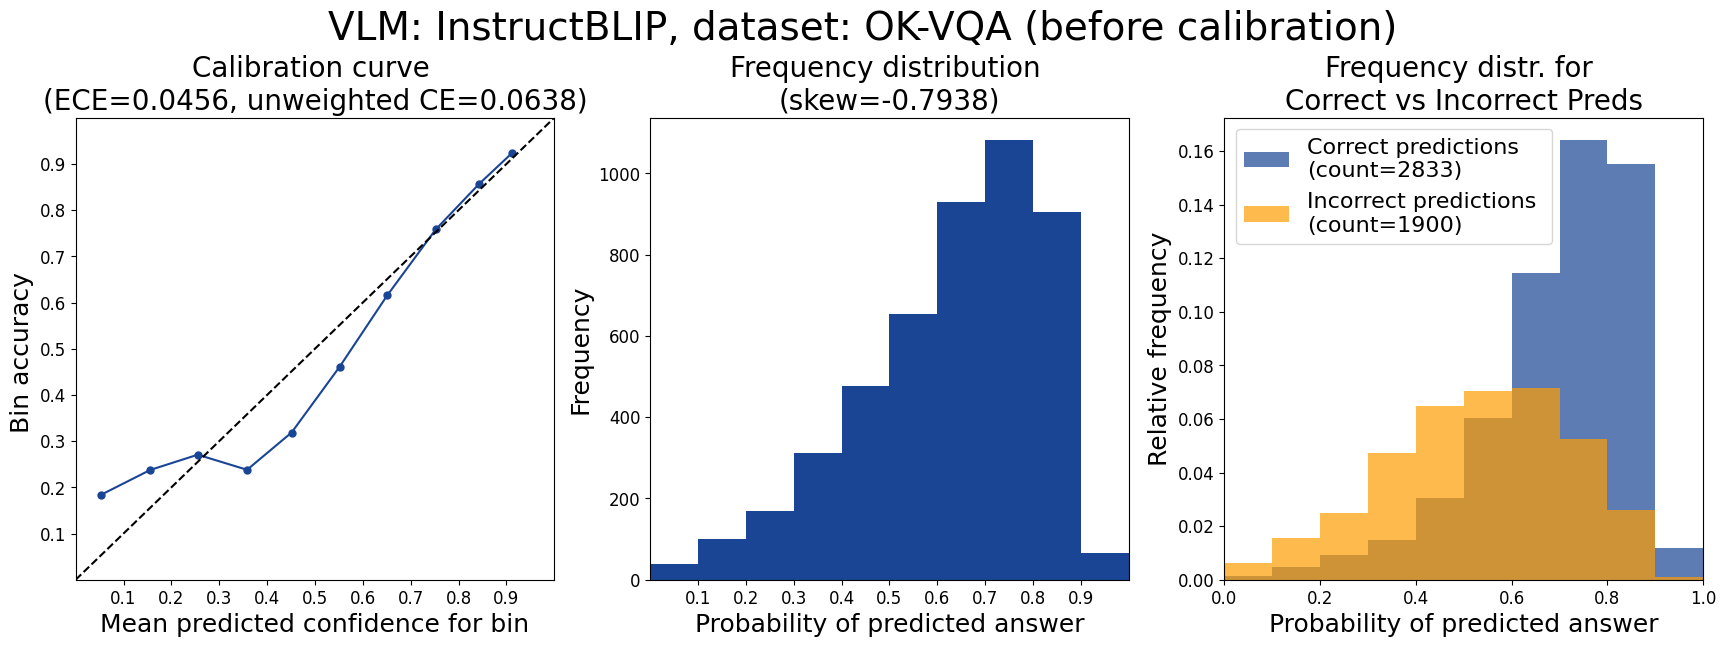

In [6]:
from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'VLM: {vlm_displayname}, dataset: {dataset_displayname} (before calibration)\n\n', fontsize=28, y=1.06)
fig.set_size_inches(21, 6)
ax1.plot(bin_meanprobs, bin_accs, marker='.', markersize=10, color='#1a4595')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve \n(ECE={calibration_error:.4f}, unweighted CE={unweighted_calibration_error:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=18)
ax1.set_ylabel('Bin accuracy ', fontsize=18)

freqhist_bins = np.linspace(0, 1, num_bins+1)
ax2.hist(
    predicted_answer_probs, 
    freqhist_bins, 
    color='#1a4595', 
    #weights=np.ones_like(predicted_answer_probs) / len(qids)
)
ax2.set_title(f'Frequency distribution \n(skew={freqdistr_skew:.4f})', fontsize=20)
ax2.set_xlabel('Probability of predicted answer', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])#, fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)


ax3.hist(
    correct_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#1a4595', 
    label='Correct predictions \n(count={})'.format(len(correct_probs)), 
    weights=np.ones_like(correct_probs) / len(qids))
ax3.hist(
    incorrect_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#ff9d02', 
    label='Incorrect predictions \n(count={})'.format(len(incorrect_probs)), 
    weights=np.ones_like(incorrect_probs) / len(qids))
ax3.set_title(f'Frequency distr. for \nCorrect vs Incorrect Preds', fontsize=20)
ax3.set_xlabel('Probability of predicted answer', fontsize=18)
ax3.set_ylabel('Relative frequency', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(loc='upper left', fontsize=16)
ax3.set_xlim(0, 1)
plt.show()


In [7]:


correct_preds_confdistribution = []
for i in range(10):
    x = [c for c in correct_probs if c >= i/10 and c < (i+1)/10]
    correct_preds_confdistribution.append(len(x))

incorrect_preds_confdistribution = []
for i in range(10):
    x = [c for c in incorrect_probs if c >= i/10 and c < (i+1)/10]
    incorrect_preds_confdistribution.append(len(x))
    
out_data = {
    'correct_preds_confdistribution': correct_preds_confdistribution,
    'incorrect_preds_confdistribution': incorrect_preds_confdistribution,
    'bin_meanprobs': bin_meanprobs,
    'bin_accs': bin_accs,
    'calibration_error': calibration_error,
}
out_fn = f"/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/uncalibrated_{vlm_name}-{dataset_name}_{mode}-5000examples.json"
json.dump(out_data, open(out_fn, 'w'), indent=2)

## Extract logits of yes-no tokens for VLM

In [ ]:
!gpustat

In [ ]:
from models.llm import LLM_CLASS_MAP
from models.vlm import VLM_CLASS_MAP
from models.qgen import QGEN_CLASS_MAP

#config_file = '/net/nfs.cirrascale/mosaic/tejass/code/ReCoVERR/configs/recoverr_configs/aokvqa/chatgpt_qgen-flant5xl_llm-instructblipft5xl_vlm.yaml'
vlm_name = 'instructblipflant5xl'
#vlm_name = 'blip2flant5xl'
config_file = f"/net/nfs.cirrascale/mosaic/tejass/code/ReCoVERR/configs/recoverr_011924/chatgpt_qgen-flant5xl_llm-{vlm_name.replace('flant5', 'ft5')}_vlm-detr_objdet.yaml"
device = torch.device("cuda")
# Create agent and environment
config = yaml.safe_load(open(config_file))

# Load VLM
vlm_class = config['vlm']['class_name']
vlm_model_class = VLM_CLASS_MAP[vlm_class]
vlm_config = yaml.safe_load(open(config['vlm']['model_config_path']))
vlm_model = vlm_model_class(vlm_config, device)
vlm_model.set_vqa_inference_params(config['vlm']['vqa_inference_params'])
vlm_model.set_caption_inference_params(config['vlm']['caption_inference_params'])

In [ ]:
yn_outputs_file = f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/uncalibrated_yn_probs/{vlm_name}-{dataset_name}_{split}_{mode}.json'
directvqa_rollouts = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/directvqa/{dataset_name}_{mode}/train_outputs/{vlm_name}_direct_vqa-1rollouts-{dataset_size}examples.json'))


results = []
for i, d in enumerate(tqdm(dataset)):
    #continue
    question = d['question']
    image = d['raw_image']
    qid = d['qid']
    answer, logprobs_dict = vlm_model.ask(image, question)
    r = directvqa_rollouts[str(qid)][0]
    result = {
        "qid": qid,
        "image_id": r['image_id'],
        "question": r['vqa_question'],
        "answer": answer,
        "yn_logits": logprobs_dict['yn_logits'], 
        "yn_prob": logprobs_dict['yn_prob'],
        "lave_score": r['lave_score'], 
    }
    results.append(result)
    #if i == 100:
    #    break

json.dump(results, open(yn_outputs_file, 'w'), indent=2)

## Train Logistic Regression Calibration Model

In [8]:
import numpy as np
#yn_outputs_file = f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/uncalibrated_yn_probs/{vlm_name}-{dataset_name}_{split}_{mode}.json'
#results = json.load(open(yn_outputs_file))

directvqa_rollouts = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/directvqa/{dataset_name}_{mode}/train_outputs/{vlm_name}_direct_vqa-1rollouts-{dataset_size}examples.json'))
results = [r[0] for r in directvqa_rollouts.values()]

X, y = [], []
for r in results:
    #if r['lave_score'] not in [0, 1]:
    #    continue
    X.append(r['answer_logprobs_dict']['yn_logits'])
    y.append(r['lave_score'])
X_test = X[:5000]
y_test  = y[:5000]
X_train = X[5000:]
y_train = y[5000:]

# Remove ambiguous samples
X_train = np.array([x for i, x in enumerate(X_train) if y_train[i] in [0.0, 1.0]])# and dataset.data[i]['difficult_direct_answer'] is False])
y_train = np.array([y for i, y in enumerate(y_train) if y_train[i] in [0.0, 1.0]])# and dataset.data[i]['difficult_direct_answer'] is False])
X_test = np.array([x for i, x in enumerate(X_test) if y_test[i] in [0, 1]]) #and dataset.data[i]['difficult_direct_answer'] is False])
y_test = np.array([y for i, y in enumerate(y_test) if y_test[i] in [0, 1]])# and dataset.data[i]['difficult_direct_answer'] is False])

print("Number of training samples for calibrator model:", X_train.shape)
print("Number of test samples for calibrator model:", X_test.shape)

Number of training samples for calibrator model: (3830, 2)
Number of test samples for calibrator model: (4733, 2)


In [10]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=1, solver='lbfgs')
lr_model.fit(X_train, y_train)

LogisticRegression(C=1)

In [11]:
import pickle as pkl

out_fn = f"/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_model/calibrated_{vlm_name}-{dataset_name}_{mode}-calibration_clf.pkl"
pkl.dump(lr_model, open(out_fn, 'wb'))

In [12]:
import pickle as pkl

out_fn = f"/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_model/calibrated_{vlm_name}-{dataset_name}_{mode}-calibration_clf.pkl"
lr_model = pkl.load(open(out_fn, 'rb'))

In [13]:
y_test_calibrated_probs = lr_model.predict_proba(X_test)
predicted_answer_probs = [y[1] for y in y_test_calibrated_probs]
predicted_answer_accs = y_test.tolist()

In [14]:
bin_accs, bin_meanprobs, bin_sizes, bin_stdprobs = [], [], [], []
num_bins = 10
for i in range(num_bins):
    bin_lower = i*1.0/num_bins
    bin_upper = (i+1)*1.0/num_bins
    bin_idxs = [i for i in range(len(predicted_answer_accs)) if predicted_answer_probs[i] >= bin_lower and predicted_answer_probs[i] < bin_upper]
    print(f"Bin {bin_lower:.2f}-{bin_upper:.2f}: {len(bin_idxs)} instances")
    bin_individualaccs = [predicted_answer_accs[i] for i in bin_idxs]
    bin_individualprobs = [predicted_answer_probs[i] for i in bin_idxs]
    print(f"Bin accuracy: {np.mean(bin_individualaccs):.2%}")
    print(f"Mean predicted probability for bin: {np.mean(bin_individualprobs):.2%}")
    bin_accs.append(np.mean(bin_individualaccs))
    bin_meanprobs.append(np.mean(bin_individualprobs))
    bin_sizes.append(len(bin_idxs))
    bin_stdprobs.append(np.std(bin_individualprobs))

Bin 0.00-0.10: 73 instances
Bin accuracy: 20.55%
Mean predicted probability for bin: 5.71%
Bin 0.10-0.20: 143 instances
Bin accuracy: 27.27%
Mean predicted probability for bin: 15.14%
Bin 0.20-0.30: 227 instances
Bin accuracy: 20.70%
Mean predicted probability for bin: 25.24%
Bin 0.30-0.40: 345 instances
Bin accuracy: 28.41%
Mean predicted probability for bin: 35.28%
Bin 0.40-0.50: 418 instances
Bin accuracy: 35.17%
Mean predicted probability for bin: 45.13%
Bin 0.50-0.60: 553 instances
Bin accuracy: 46.29%
Mean predicted probability for bin: 55.04%
Bin 0.60-0.70: 700 instances
Bin accuracy: 61.71%
Mean predicted probability for bin: 65.20%
Bin 0.70-0.80: 816 instances
Bin accuracy: 69.24%
Mean predicted probability for bin: 75.14%
Bin 0.80-0.90: 1016 instances
Bin accuracy: 82.48%
Mean predicted probability for bin: 85.03%
Bin 0.90-1.00: 442 instances
Bin accuracy: 89.59%
Mean predicted probability for bin: 92.59%


In [15]:
correct_probs, incorrect_probs = [], []
correct_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 1]
incorrect_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 0]

correct_probs = [predicted_answer_probs[i] for i in correct_idxs]
incorrect_probs = [predicted_answer_probs[i] for i in incorrect_idxs]
print(f"{len(correct_probs)} correct predictions, {len(incorrect_probs)} incorrect predictions")

2833 correct predictions, 1900 incorrect predictions


In [16]:
unweighted_calibration_error = np.mean(np.abs(np.array(bin_accs) - np.array(bin_meanprobs)))
calibration_error = np.sum((np.abs(np.array(bin_accs) - np.array(bin_meanprobs)))*np.array(bin_sizes))/len(y_test)


from scipy.stats import pearsonr, skew
freqdistr_skew = skew(predicted_answer_probs)
#r = pearsonr(prob_true, prob_pred)
#print(r.statistic)

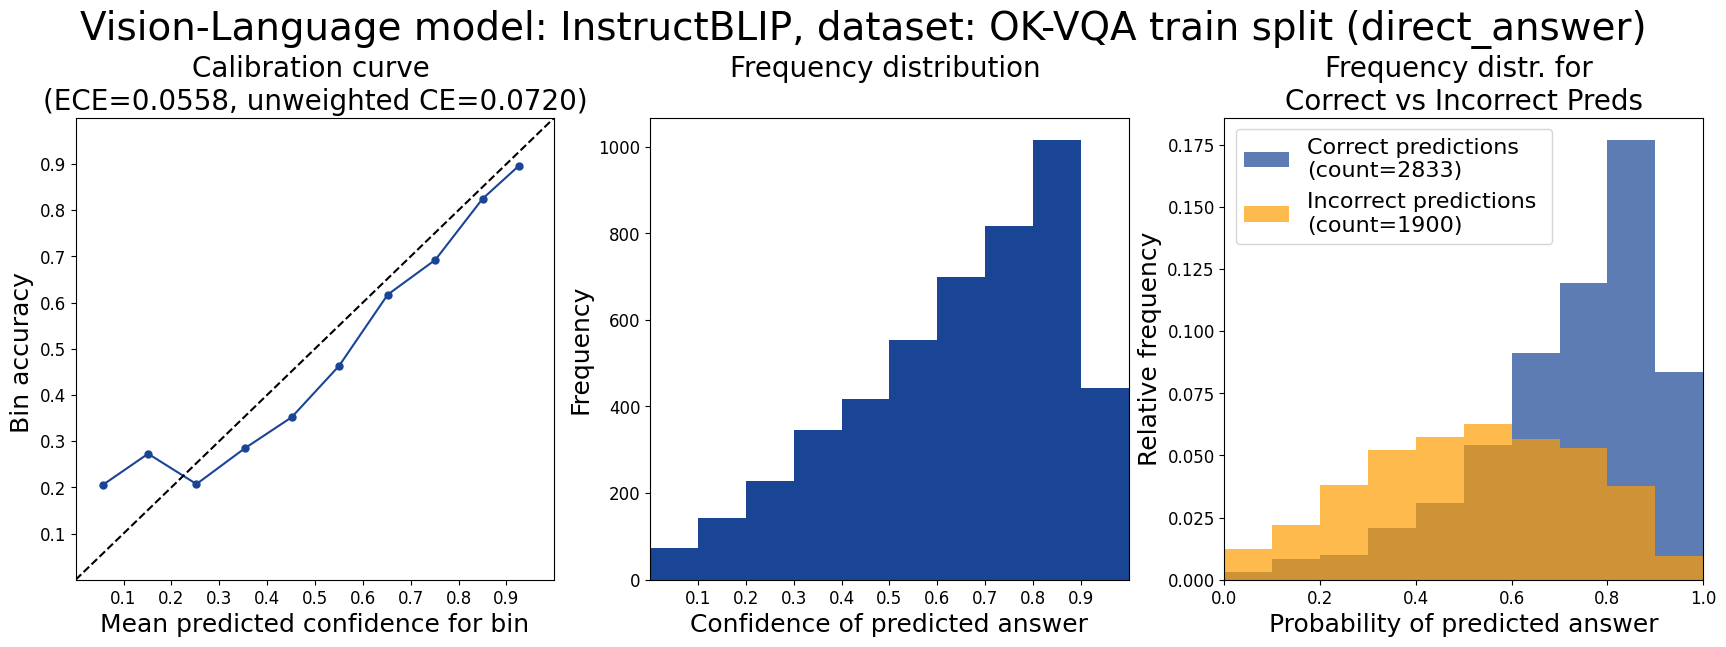

In [17]:
from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Vision-Language model: {vlm_displayname}, dataset: {dataset_displayname} train split ({mode})\n\n', fontsize=28, y=1.06)
fig.set_size_inches(21, 6)
ax1.plot(bin_meanprobs, bin_accs, marker='.', markersize=10, color='#1a4595')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve \n(ECE={calibration_error:.4f}, unweighted CE={unweighted_calibration_error:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=18)
ax1.set_ylabel('Bin accuracy ', fontsize=18)

freqhist_bins = np.linspace(0, 1, num_bins+1)
ax2.hist(
    predicted_answer_probs, 
    freqhist_bins, 
    color='#1a4595', 
    #color='#ff9d02',
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
)
ax2.set_title(f'Frequency distribution \n', fontsize=20)
ax2.set_xlabel('Confidence of predicted answer', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])#, fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)


ax3.hist(
    correct_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#1a4595', 
    label='Correct predictions \n(count={})'.format(len(correct_probs)), 
    weights=np.ones_like(correct_probs) / len(y_test))
ax3.hist(
    incorrect_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#ff9d02', 
    label='Incorrect predictions \n(count={})'.format(len(incorrect_probs)), 
    weights=np.ones_like(incorrect_probs) / len(y_test))
ax3.set_title(f'Frequency distr. for \nCorrect vs Incorrect Preds', fontsize=20)
ax3.set_xlabel('Probability of predicted answer', fontsize=18)
ax3.set_ylabel('Relative frequency', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(loc='upper left', fontsize=16)
ax3.set_xlim(0, 1)
plt.show()


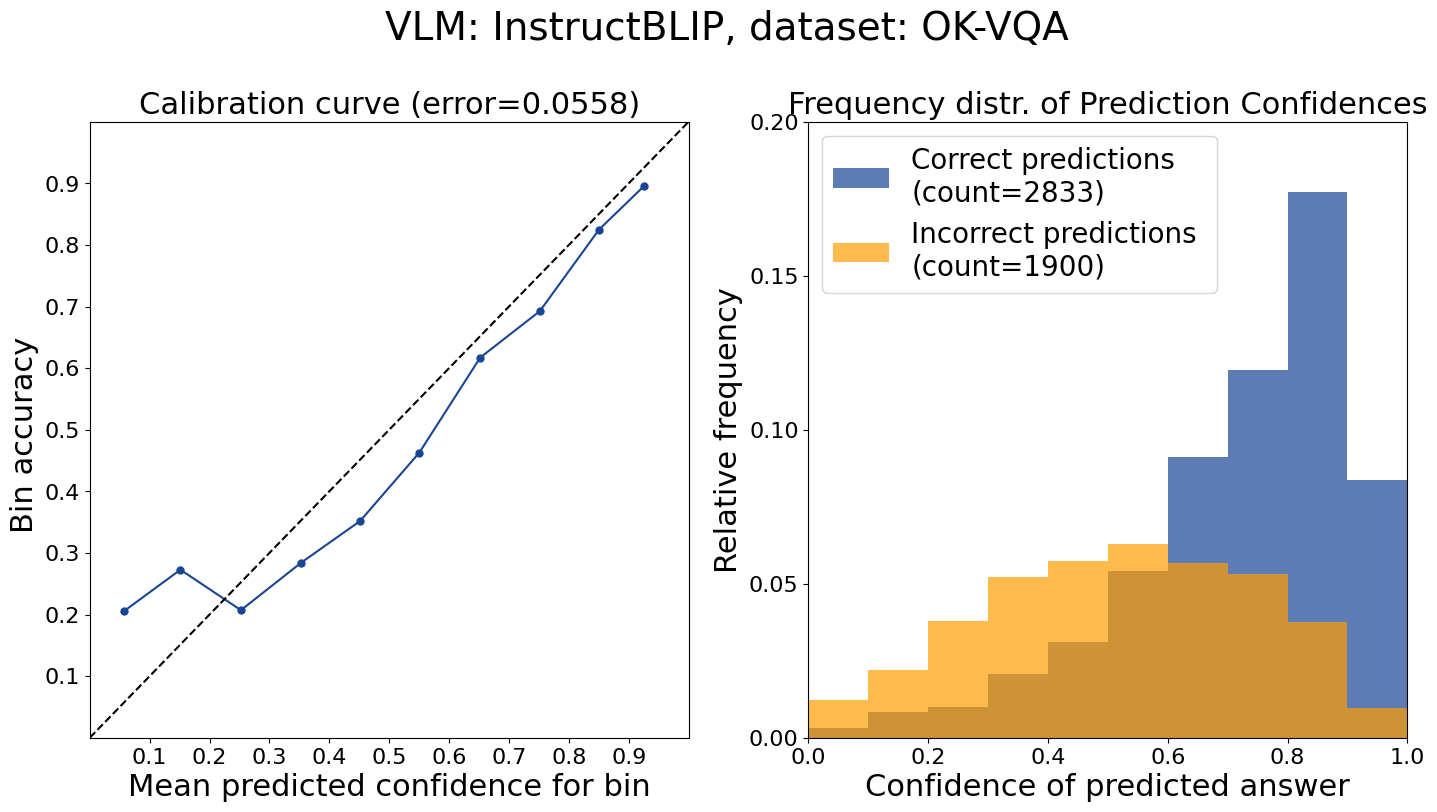

In [18]:
from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle(f'VLM: {vqa_model_displayname}, dataset: {dataset_displayname} train split ({mode})\n\n', fontsize=28, y=1.02)
fig.suptitle(f'VLM: {vlm_displayname}, dataset: {dataset_displayname}\n', fontsize=28, y=1.02)
fig.set_size_inches(17, 8)
ax1.plot(bin_meanprobs, bin_accs, marker='.', markersize=10, color='#1a4595')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve (error={calibration_error:.4f})', fontsize=22)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=22)
ax1.set_ylabel('Bin accuracy ', fontsize=22)

freqhist_bins = np.linspace(0, 1, num_bins+1)
ax2.hist(
    correct_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#1a4595', 
    label='Correct predictions \n(count={})'.format(len(correct_probs)), 
    weights=np.ones_like(correct_probs) / len(y_test))
ax2.hist(
    incorrect_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#ff9d02', 
    label='Incorrect predictions \n(count={})'.format(len(incorrect_probs)), 
    weights=np.ones_like(incorrect_probs) / len(y_test))
ax2.set_title(f'Frequency distr. of Prediction Confidences', fontsize=22)
ax2.set_xlabel('Confidence of predicted answer', fontsize=22)
ax2.set_ylabel('Relative frequency', fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlim(0, 1)
ax2.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
plt.show()


In [19]:


correct_preds_confdistribution = []
for i in range(10):
    x = [c for c in correct_probs if c >= i/10 and c < (i+1)/10]
    correct_preds_confdistribution.append(len(x))

incorrect_preds_confdistribution = []
for i in range(10):
    x = [c for c in incorrect_probs if c >= i/10 and c < (i+1)/10]
    incorrect_preds_confdistribution.append(len(x))
    
out_data = {
    'correct_preds_confdistribution': correct_preds_confdistribution,
    'incorrect_preds_confdistribution': incorrect_preds_confdistribution,
    'bin_meanprobs': bin_meanprobs,
    'bin_accs': bin_accs,
    'calibration_error': calibration_error,
}
out_fn = f"/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_{vlm_name}-{dataset_name}_{mode}-{len(y_train)}train_{len(y_test)}test_examples.json"
json.dump(out_data, open(out_fn, 'w'), indent=2)

## Analyze Calibrated vs uncalibrated Confidence Distributions

2833
2833
1900
1900


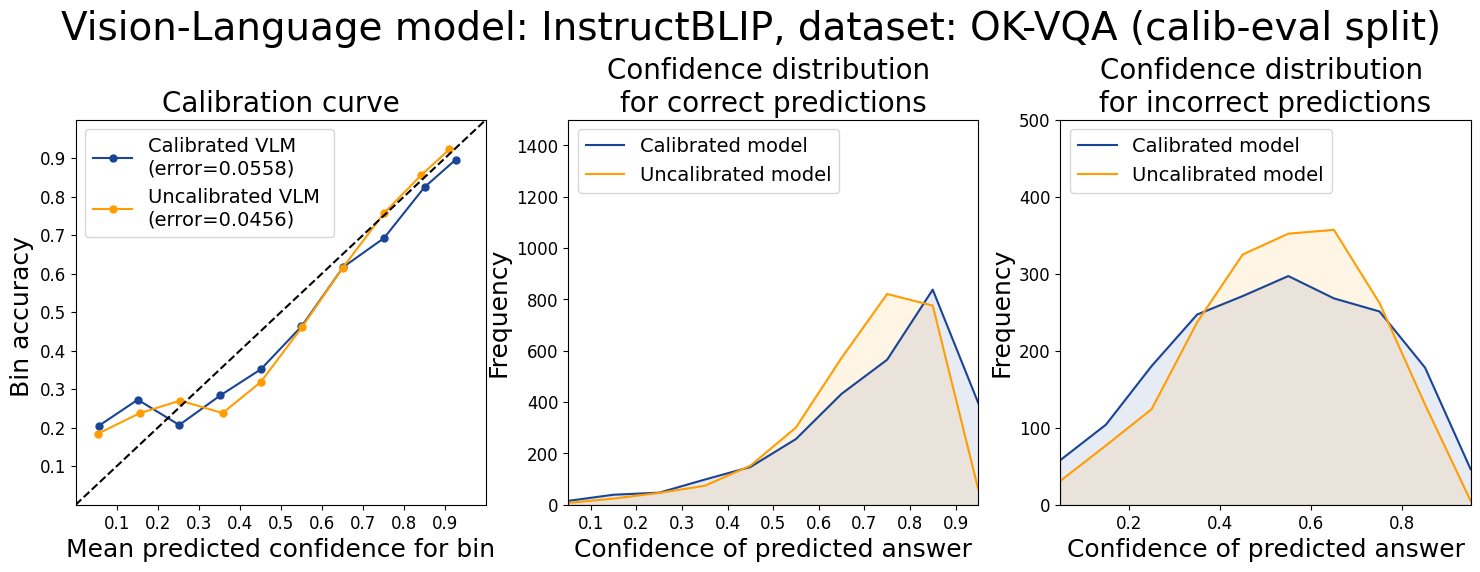

In [20]:
import json
import numpy as np
uncalibrated_data = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/uncalibrated_{vlm_name}-{dataset_name}_direct_answer-5000examples.json'))
calibrated_data = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_{vlm_name}-{dataset_name}_direct_answer-{len(y_train)}train_{len(y_test)}test_examples.json'))

from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Vision-Language model: {vlm_displayname}, dataset: {dataset_displayname} (calib-eval split)\n\n', fontsize=28, y=1.1)
fig.set_size_inches(18, 5)
ax1.plot(
    calibrated_data['bin_meanprobs'], 
    calibrated_data['bin_accs'], 
    marker='.', markersize=10, 
    label=f"Calibrated VLM \n(error={calibrated_data['calibration_error']:.4f})",
    color='#1a4595')
ax1.plot(
    uncalibrated_data['bin_meanprobs'], 
    uncalibrated_data['bin_accs'], 
    marker='.', markersize=10, 
    label=f"uncalibrated VLM \n(error={uncalibrated_data['calibration_error']:.4f})",
    color='#ff9d02')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=18)
ax1.set_ylabel('Bin accuracy ', fontsize=18)
ax1.legend(loc='upper left', fontsize=14)

#freqhist_bins = np.linspace(0, 1, num_bins+1)
bar_x = [i/10+0.05 for i in range(10)]
print(sum(calibrated_data['correct_preds_confdistribution']))
print(sum(uncalibrated_data['correct_preds_confdistribution']))
ax2.plot(
    bar_x,
    calibrated_data['correct_preds_confdistribution'],
    color='#1a4595', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Calibrated model',
)
ax2.fill_between(
    bar_x,
    calibrated_data['correct_preds_confdistribution'],
    color='#1a4595', 
    alpha=0.1,
)
ax2.plot(
    bar_x,
    uncalibrated_data['correct_preds_confdistribution'],
    color='#ff9d02', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='uncalibrated model',
)
ax2.fill_between(
    bar_x,
    uncalibrated_data['correct_preds_confdistribution'],
    color='#ff9d02', 
    alpha=0.1,
)
ax2.set_title(f'Confidence distribution \nfor correct predictions', fontsize=20)
ax2.set_xlabel('Confidence of predicted answer', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])#, fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0.05, 0.95)
ax2.set_ylim(0, 1500)
ax2.legend(loc='upper left', fontsize=14)

print(sum(calibrated_data['incorrect_preds_confdistribution']))
print(sum(uncalibrated_data['incorrect_preds_confdistribution']))
ax3.plot(
    bar_x,
    calibrated_data['incorrect_preds_confdistribution'],
    color='#1a4595', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Calibrated model',
)
ax3.fill_between(
    bar_x,
    calibrated_data['incorrect_preds_confdistribution'],
    color='#1a4595', 
    alpha=0.1,
)
ax3.plot(
    bar_x,
    uncalibrated_data['incorrect_preds_confdistribution'],
    color='#ff9d02', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Off-the-shelf model',
)
ax3.fill_between(
    bar_x,
    uncalibrated_data['incorrect_preds_confdistribution'],
    color='#ff9d02', 
    alpha=0.1,
)

ax3.set_title(f'Confidence distribution \nfor incorrect predictions', fontsize=20)
ax3.set_xlabel('Confidence of predicted answer', fontsize=18)
ax3.set_ylabel('Frequency', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(loc='upper left', fontsize=14)
ax3.set_xlim(0.05, 0.95)
ax3.set_ylim(0, 500)
plt.show()


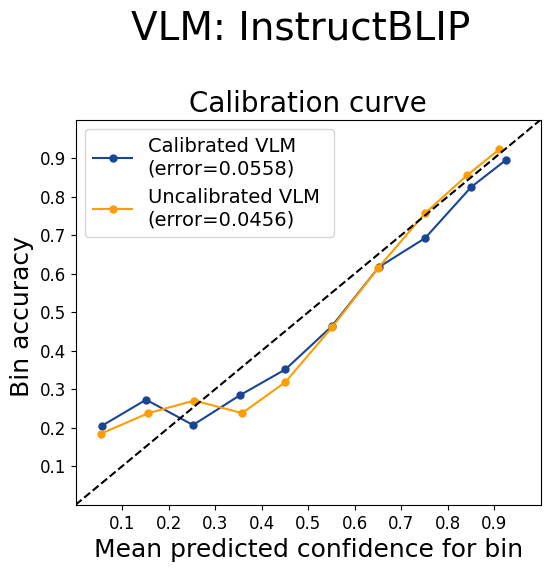

In [21]:
import json
import numpy as np
uncalibrated_data = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/uncalibrated_{vlm_name}-{dataset_name}_direct_answer-5000examples.json'))
calibrated_data = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_{vlm_name}-{dataset_name}_direct_answer-{len(y_train)}train_{len(y_test)}test_examples.json'))

from matplotlib import pyplot as plt
plt.size = (20, 25)
fig, ax1 = plt.subplots(1, 1)
fig.suptitle(f'VLM: {vlm_displayname}\n\n', fontsize=28, y=1.1)
fig.set_size_inches(6, 5)
ax1.plot(
    calibrated_data['bin_meanprobs'], 
    calibrated_data['bin_accs'], 
    marker='.', markersize=10, 
    label=f"Calibrated VLM \n(error={calibrated_data['calibration_error']:.4f})",
    color='#1a4595')
ax1.plot(
    uncalibrated_data['bin_meanprobs'], 
    uncalibrated_data['bin_accs'], 
    marker='.', markersize=10, 
    label=f"Off-the-shelf VLM \n(error={uncalibrated_data['calibration_error']:.4f})",
    color='#ff9d02')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=18)
ax1.set_ylabel('Bin accuracy ', fontsize=18)
ax1.legend(loc='upper left', fontsize=14)

plt.show()


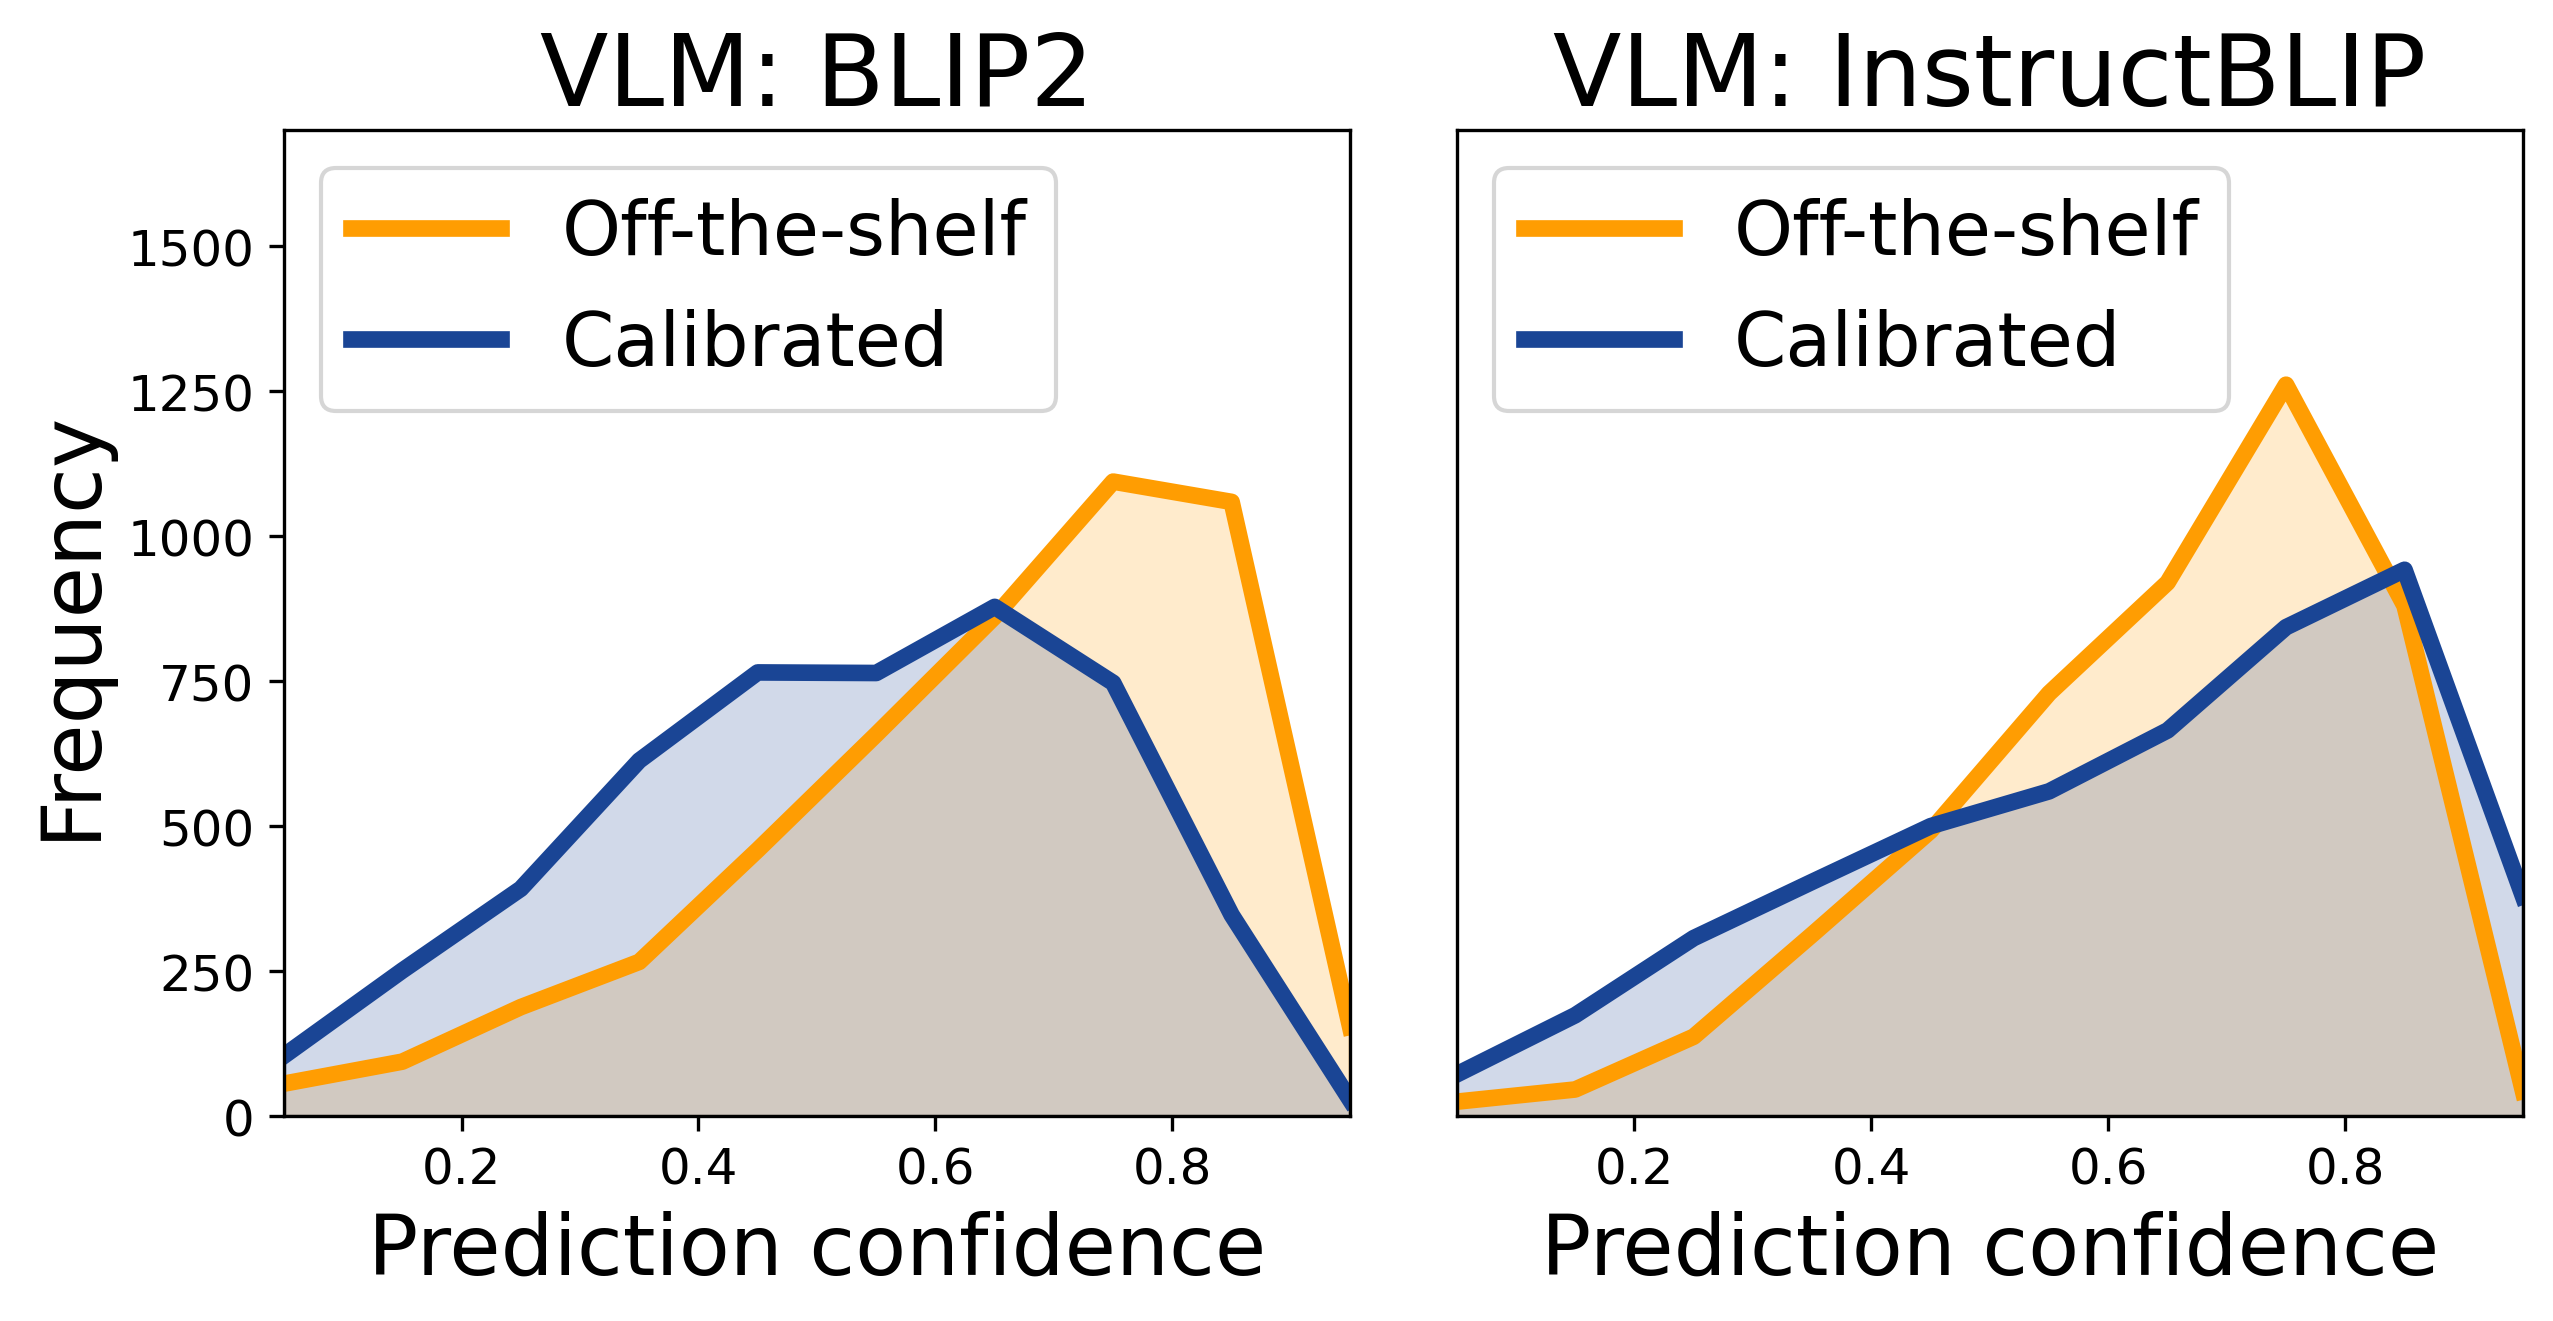

In [180]:
import json
import numpy as np
ib_uncalib_data = json.load(open("/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/uncalibrated_instructblipflant5xl-aokvqa_direct_answer-5000examples.json"))
ib_calib_data = json.load(open("/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_instructblipflant5xl-aokvqa_direct_answer-11761train_4846test_examples.json"))
b2_uncalib_data = json.load(open("/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/uncalibrated_blip2flant5xl-aokvqa_direct_answer-5000examples.json"))
b2_calib_data = json.load(open("/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_blip2flant5xl-aokvqa_direct_answer-11802train_4889test_examples.json"))

from matplotlib import pyplot as plt
plt.size = (20, 25)
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle(f"Confidence distributions for VLMs' predictions\n", fontsize=24, y=1.05)
fig.tight_layout(pad=0)
fig.set_size_inches(8,3.5)
bar_x = [i/10+0.05 for i in range(10)]
ax1.plot(
    bar_x,
    np.array(b2_uncalib_data['incorrect_preds_confdistribution'])+np.array(b2_uncalib_data['correct_preds_confdistribution']),
    color='#ff9d02', 
    linewidth=4, 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Off-the-shelf',
)
ax1.fill_between(
    bar_x,
    np.array(b2_uncalib_data['incorrect_preds_confdistribution'])+np.array(b2_uncalib_data['correct_preds_confdistribution']),
    color='#ff9d02', 
    alpha=0.2,
)
ax1.plot(
    bar_x,
    np.array(b2_calib_data['incorrect_preds_confdistribution'])+np.array(b2_calib_data['correct_preds_confdistribution']),
    color='#1a4595', 
    linewidth=4, 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Calibrated',
)
ax1.fill_between(
    bar_x,
    np.array(b2_calib_data['incorrect_preds_confdistribution'])+np.array(b2_calib_data['correct_preds_confdistribution']),
    color='#1a4595', 
    alpha=0.2,
)

ax1.set_title('VLM: BLIP2', fontsize=24)
ax1.set_xlabel('Prediction confidence', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(loc='upper left', fontsize=18)
ax1.set_xlim(0.05, 0.95)
ax1.set_ylim(0, 1700)
ax1.set_yticks([0, 250, 500, 750, 1000, 1250, 1500])


ax2.plot(
    bar_x,
    np.array(ib_uncalib_data['incorrect_preds_confdistribution'])+np.array(ib_uncalib_data['correct_preds_confdistribution']),
    color='#ff9d02', 
    linewidth=4, 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Off-the-shelf',
)
ax2.fill_between(
    bar_x,
    np.array(ib_uncalib_data['incorrect_preds_confdistribution'])+np.array(ib_uncalib_data['correct_preds_confdistribution']),
    color='#ff9d02', 
    alpha=0.2,
)
ax2.plot(
    bar_x,
    np.array(ib_calib_data['incorrect_preds_confdistribution'])+np.array(ib_calib_data['correct_preds_confdistribution']),
    color='#1a4595', 
    linewidth=4, 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Calibrated',
)
ax2.fill_between(
    bar_x,
    np.array(ib_calib_data['incorrect_preds_confdistribution'])+np.array(ib_calib_data['correct_preds_confdistribution']),
    color='#1a4595', 
    alpha=0.2,
)


ax2.set_title('VLM: InstructBLIP', fontsize=24)
ax2.set_xlabel('Prediction confidence', fontsize=20)
#ax2.set_ylabel('Frequency', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(loc='upper left', fontsize=18)
ax2.set_xlim(0.05, 0.95)
ax2.set_ylim(0, 1700)
ax2.set_yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

# Abstention

In [23]:
predicted_answer_probs = [y[1] for y in y_test_calibrated_probs]
predicted_answer_accs = y_test.tolist()

def calculate_abstention_metrics(threshold, error_cost=1):
    num_covered, total_risk, effective_reliability = 0, 0, 0
    qids = list(range(len(predicted_answer_accs)))
    abstained_qids = []
    for idx, (acc, conf) in enumerate(zip(predicted_answer_accs, predicted_answer_probs)):
        selected = True if conf >= threshold else False
        if selected:
            num_covered += 1
            total_risk += 1 - acc #if acc != 1 else 0
            effective_reliability += acc if acc > 0 else -error_cost
        else:
            abstained_qids.append(idx)
    coverage = num_covered/len(qids)
    risk = total_risk/num_covered if num_covered > 0 else 0
    effective_reliability = effective_reliability/len(qids)
    return coverage, risk, effective_reliability, abstained_qids

num_thresholds = 100
penalty = 1
thresholds = [i/num_thresholds for i in range(1, num_thresholds)]
coverages, risks, eff_reliabilities = [], [], []
for t in tqdm(thresholds):
    c, r, e, _ = calculate_abstention_metrics(t, penalty)
    coverages.append(c)
    risks.append(r)
    eff_reliabilities.append(e)
#for t, c, r in zip(thresholds, coverages, risks):
#    print(f"At confidence threshold {t}, coverage={c:.2%}, risk={r:.2%}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 789.82it/s]


In [24]:
min([thresholds[i] for i in range(num_thresholds-1) if risks[i] < 0.2])

0.72

In [25]:
for i in range(num_thresholds-1):
    print(f"At threshold {thresholds[i]}, coverage={coverages[i]:.4f}, risk={risks[i]:.4f}")

At threshold 0.01, coverage=0.9989, risk=0.4008
At threshold 0.02, coverage=0.9979, risk=0.4002
At threshold 0.03, coverage=0.9966, risk=0.4000
At threshold 0.04, coverage=0.9954, risk=0.3995
At threshold 0.05, coverage=0.9939, risk=0.3988
At threshold 0.06, coverage=0.9928, risk=0.3982
At threshold 0.07, coverage=0.9907, risk=0.3971
At threshold 0.08, coverage=0.9888, risk=0.3966
At threshold 0.09, coverage=0.9861, risk=0.3960
At threshold 0.1, coverage=0.9846, risk=0.3953
At threshold 0.11, coverage=0.9808, risk=0.3936
At threshold 0.12, coverage=0.9789, risk=0.3933
At threshold 0.13, coverage=0.9763, risk=0.3921
At threshold 0.14, coverage=0.9727, risk=0.3907
At threshold 0.15, coverage=0.9704, risk=0.3902
At threshold 0.16, coverage=0.9673, risk=0.3890
At threshold 0.17, coverage=0.9647, risk=0.3879
At threshold 0.18, coverage=0.9603, risk=0.3859
At threshold 0.19, coverage=0.9573, risk=0.3856
At threshold 0.2, coverage=0.9544, risk=0.3848
At threshold 0.21, coverage=0.9512, risk=0

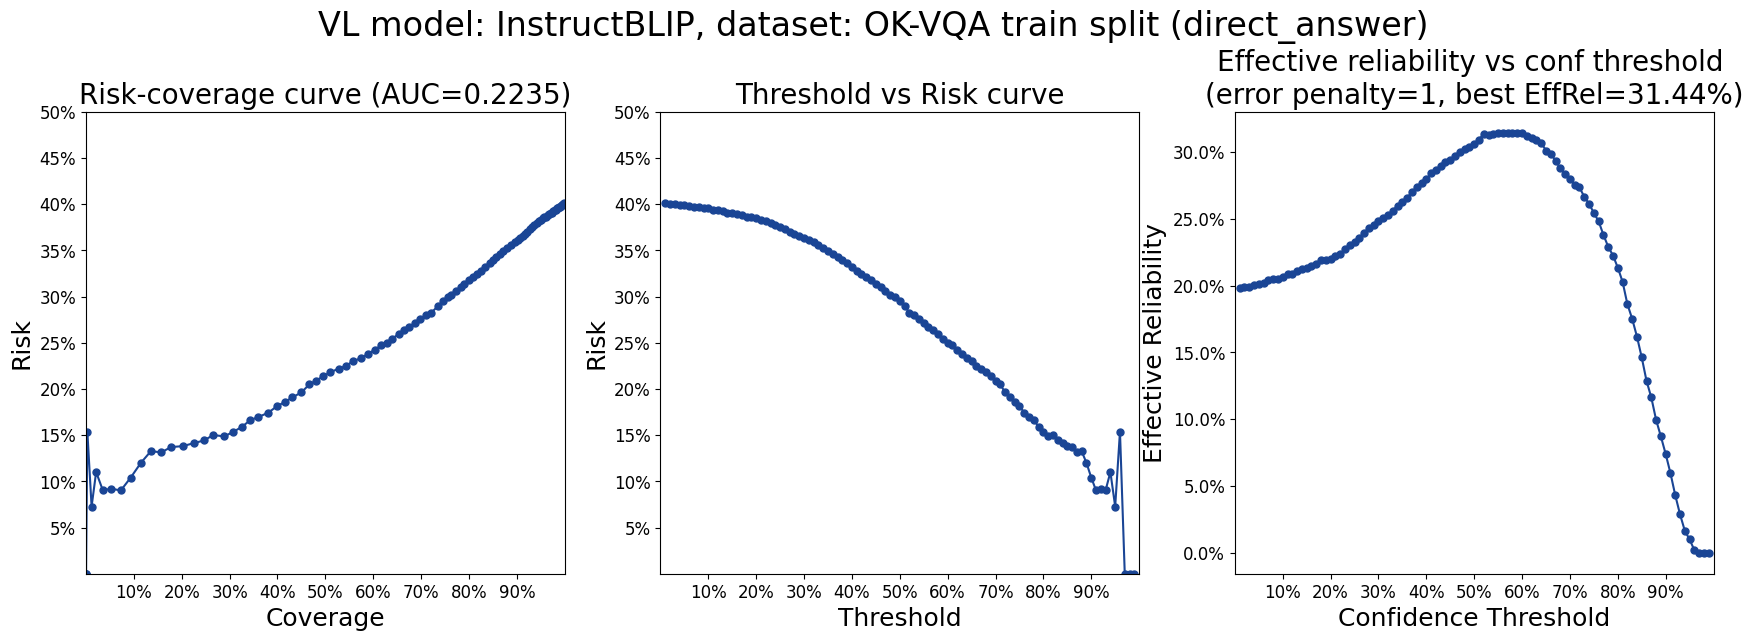

In [26]:
from sklearn import metrics
auc = metrics.auc(coverages, risks)

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'VL model: {vlm_displayname}, dataset: {dataset_displayname} train split ({mode})\n\n\n\n', fontsize=24, y=1.05)
fig.set_size_inches(21, 6)
ax1.plot(coverages, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Risk-coverage curve (AUC={auc:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Coverage', fontsize=18)
ax1.set_ylabel('Risk', fontsize=18)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2.plot(thresholds, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax2.set_title(f'Threshold vs Risk curve', fontsize=20)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax2.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.5)
ax2.set_xlabel('Threshold', fontsize=18)
ax2.set_ylabel('Risk', fontsize=18)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax3.plot(thresholds, eff_reliabilities, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax3.set_title(f'Effective reliability vs conf threshold \n(error penalty={penalty}, best EffRel={max(eff_reliabilities):.2%})', fontsize=20)
ax3.set_xticks(ticks=[i/10 for i in range(1, 10)])
#ax.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlim(0, 1)
#ax.set_ylim(0, 0.5)
ax3.set_xlabel('Confidence Threshold', fontsize=18)
ax3.set_ylabel('Effective Reliability', fontsize=18)
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

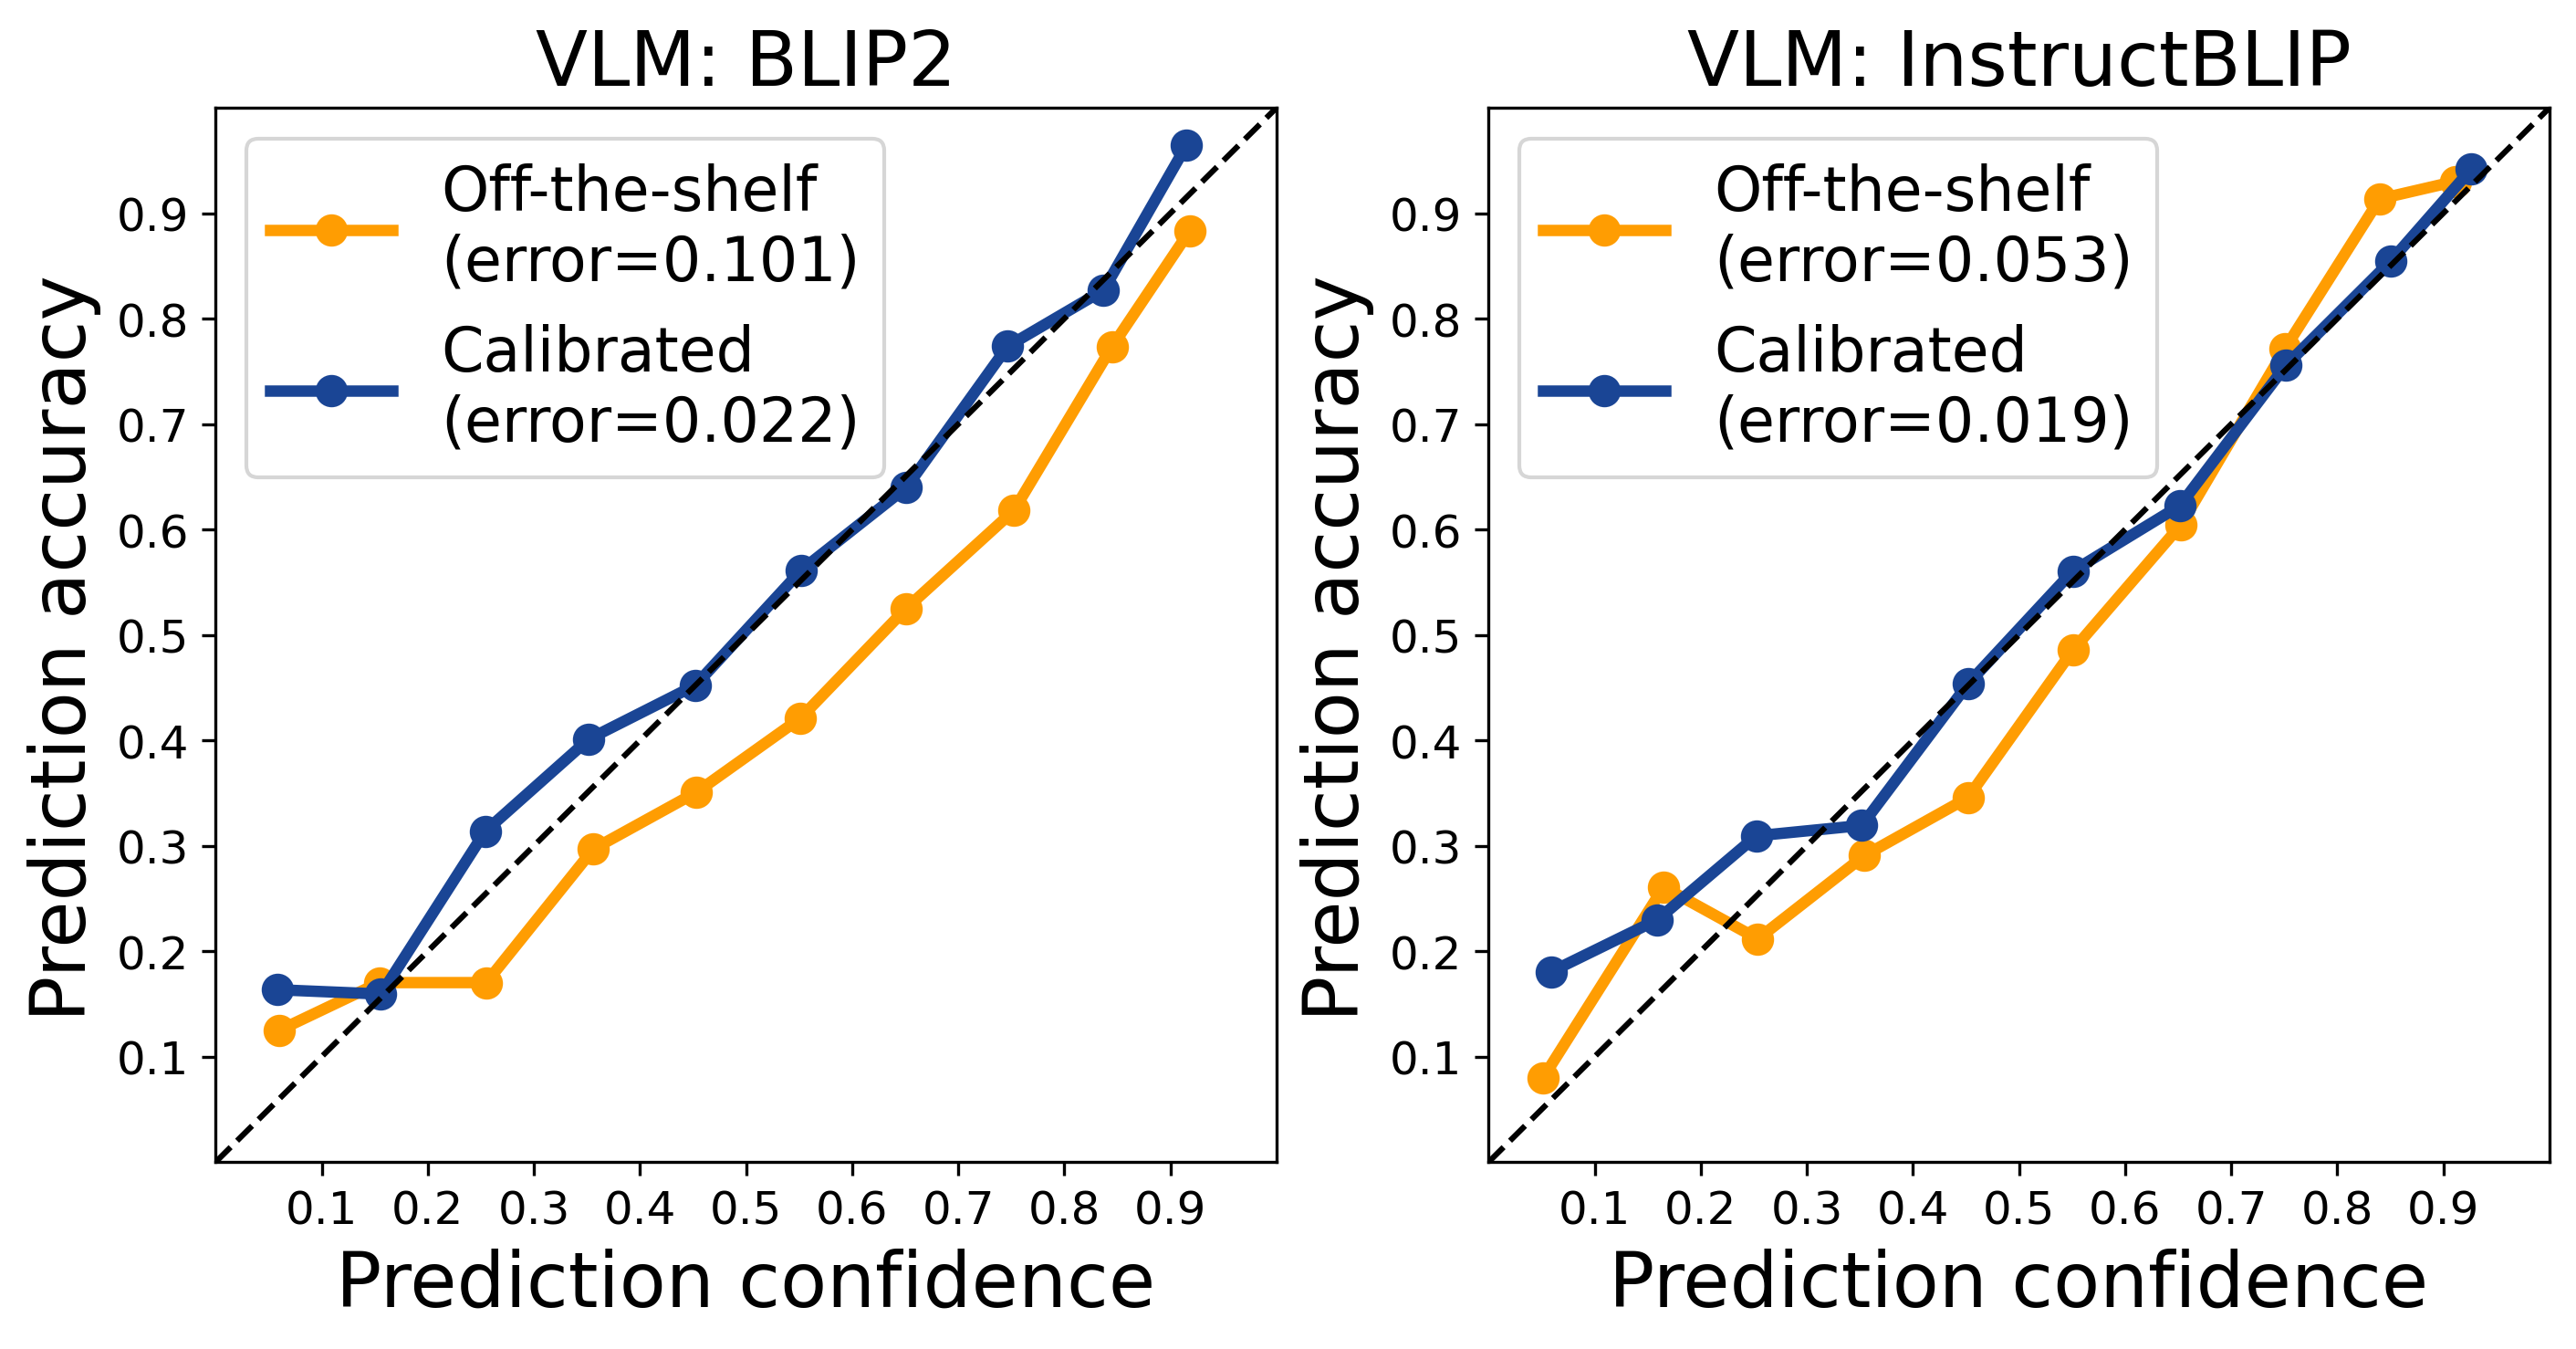

In [179]:
import json
import numpy as np
b2_uncalibrated_data = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/uncalibrated_blip2flant5xl-aokvqa_direct_answer-5000examples.json'))
b2_calibrated_data = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_blip2flant5xl-aokvqa_direct_answer-11802train_4889test_examples.json'))
ib_uncalibrated_data = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/uncalibrated_instructblipflant5xl-aokvqa_direct_answer-5000examples.json'))
ib_calibrated_data = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_instructblipflant5xl-aokvqa_direct_answer-11761train_4846test_examples.json'))

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib import pyplot as plt
plt.size = (20, 25)
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle(f'Calibration Curves for A-OKVQA\n\n', fontsize=24, y=1.05)
fig.set_size_inches(11, 5)
ax1.plot(
    b2_uncalibrated_data['bin_meanprobs'], 
    b2_uncalibrated_data['bin_accs'], 
    marker='.', markersize=15, 
    linewidth=3,
    label=f"Off-the-shelf\n(error={b2_uncalibrated_data['calibration_error']:.3f})",
    color='#ff9d02')
ax1.plot(
    b2_calibrated_data['bin_meanprobs'], 
    b2_calibrated_data['bin_accs'], 
    marker='.', markersize=15, 
    linewidth=3,
    label=f"Calibrated\n(error={b2_calibrated_data['calibration_error']:.3f})",
    color='#1a4595')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'VLM: BLIP2', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Prediction confidence', fontsize=20)
ax1.set_ylabel('Prediction accuracy ', fontsize=20)
ax1.legend(loc='upper left', fontsize=16)

ax2.plot(
    ib_uncalibrated_data['bin_meanprobs'], 
    ib_uncalibrated_data['bin_accs'], 
    marker='.', markersize=15, 
    linewidth=3,
    label=f"Off-the-shelf\n(error={ib_uncalibrated_data['calibration_error']:.3f})",
    color='#ff9d02')
ax2.plot(
    ib_calibrated_data['bin_meanprobs'], 
    ib_calibrated_data['bin_accs'], 
    marker='.', markersize=15, 
    linewidth=3,
    label=f"Calibrated\n(error={ib_calibrated_data['calibration_error']:.3f})",
    color='#1a4595')
ax2.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax2.set_title(f'VLM: InstructBLIP', fontsize=20)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax2.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Prediction confidence', fontsize=20)
ax2.set_ylabel('Prediction accuracy ', fontsize=20)
ax2.legend(loc='upper left', fontsize=16)

plt.show()


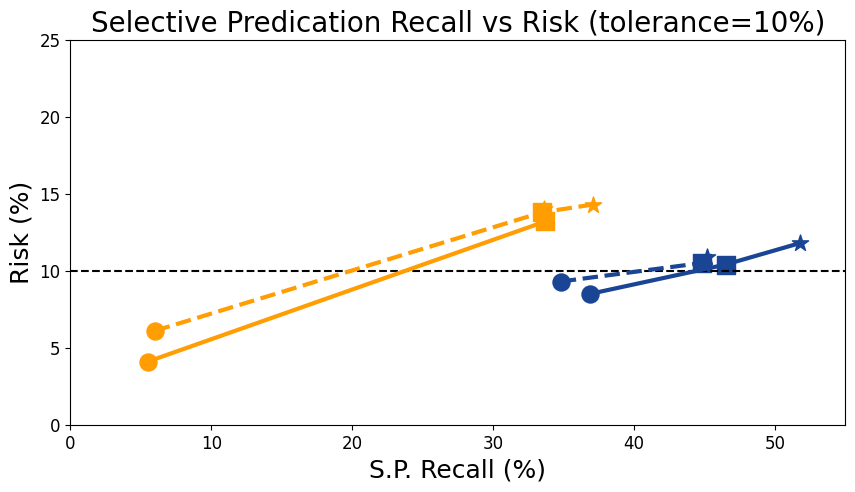

In [119]:
import json
import numpy as np

from matplotlib import pyplot as plt
plt.size = (20, 25)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
markers = ['o', 's', '*']

ax1.plot(
    [0, 55], 
    [10, 10], 
    linestyle='--',
    label=f"Risk Tolerance",
    color='k')

# Calibrated BLIP2

recall_risk_data = [
    [[6, 33.5, 37.1], [6.1, 13.8, 14.3]],
    [[5.5, 33.7, 33.6], [4.1, 13.2, 14]],
    [[34.8, 44.8, 45.2], [9.3, 10.5, 10.9]],
    [[36.9, 46.5, 51.8], [8.5, 10.4, 11.8]]
]
model_names = ["Off-the-shelf BLIP2", "Calibrated BLIP2", "Off-the-shelf InstructBLIP", "Calibrated InstructBLIP"]
linestyles = ['dashed', 'solid', 'dashed', 'solid']
colors = ['#ff9d02', '#ff9d02', '#1a4595', '#1a4595']

for i in range(4):
    data = recall_risk_data[i]
    ax1.plot(
        data[0], 
        data[1], 
        label=model_names[i],
        linewidth=3,
        linestyle=linestyles[i],
        color=colors[i])
    for j, (x, y) in enumerate(zip(data[0], data[1])):
        ax1.scatter(x, y, marker=markers[j], s=150, color=colors[i])


#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Selective Predication Recall vs Risk (tolerance=10%)', fontsize=20)
ax1.set_xticks(ticks=[i*10 for i in range(6)])
ax1.set_yticks(ticks=[i*5 for i in range(6)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 55)
ax1.set_ylim(0, 25)
ax1.set_xlabel('S.P. Recall (%)', fontsize=18)
ax1.set_ylabel('Risk (%)', fontsize=18)
#ax1.legend(loc='lower right', fontsize=14)

plt.show()


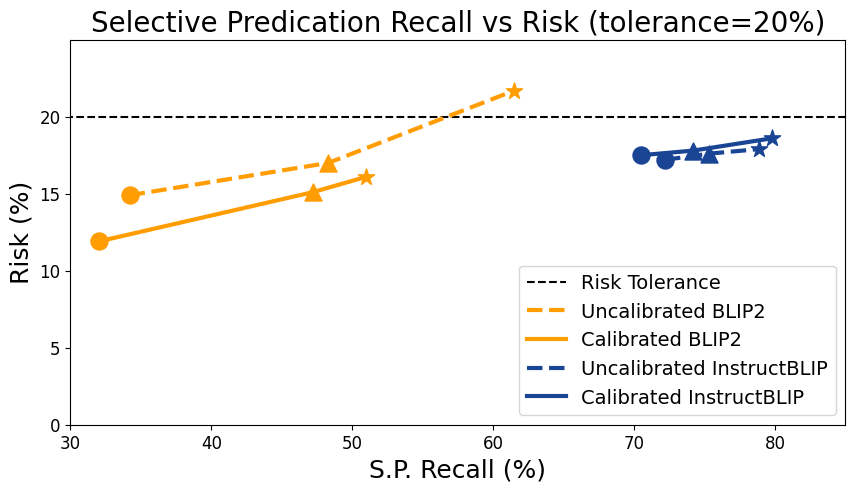

In [120]:
import json
import numpy as np

from matplotlib import pyplot as plt
plt.size = (20, 25)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
markers = ['o', '^', '*']

ax1.plot(
    [0, 100], 
    [20, 20], 
    linestyle='--',
    label=f"Risk Tolerance",
    color='k')

# Calibrated BLIP2

recall_risk_data = [
    [[34.2, 48.3, 61.5], [14.9, 17, 21.7]],
    [[32, 47.2, 51], [11.9, 15.1, 16.1]],
    [[72.2, 75.3, 78.9], [17.2, 17.6, 17.9]],
    [[70.5, 74.2, 79.8], [17.5, 17.8, 18.6]]
]
model_names = ["Off-the-shelf BLIP2", "Calibrated BLIP2", "Off-the-shelf InstructBLIP", "Calibrated InstructBLIP"]
linestyles = ['dashed', 'solid', 'dashed', 'solid']
colors = ['#ff9d02', '#ff9d02', '#1a4595', '#1a4595']

for i in range(4):
    data = recall_risk_data[i]
    ax1.plot(
        data[0], 
        data[1], 
        label=model_names[i],
        linewidth=3,
        linestyle=linestyles[i],
        color=colors[i])
    for j, (x, y) in enumerate(zip(data[0], data[1])):
        ax1.scatter(x, y, marker=markers[j], s=150, color=colors[i])
        #ax1.scatter(x, y, marker=markers[j], s=150, facecolors='white', edgecolors=colors[i], alpha=1)


#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Selective Predication Recall vs Risk (tolerance=20%)', fontsize=20)
ax1.set_xticks(ticks=[i*10 for i in range(11)])
ax1.set_yticks(ticks=[i*5 for i in range(5)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(30, 85)
ax1.set_ylim(0, 25)
ax1.set_xlabel('S.P. Recall (%)', fontsize=18)
ax1.set_ylabel('Risk (%)', fontsize=18)
ax1.legend(loc='lower right', fontsize=14)

plt.show()


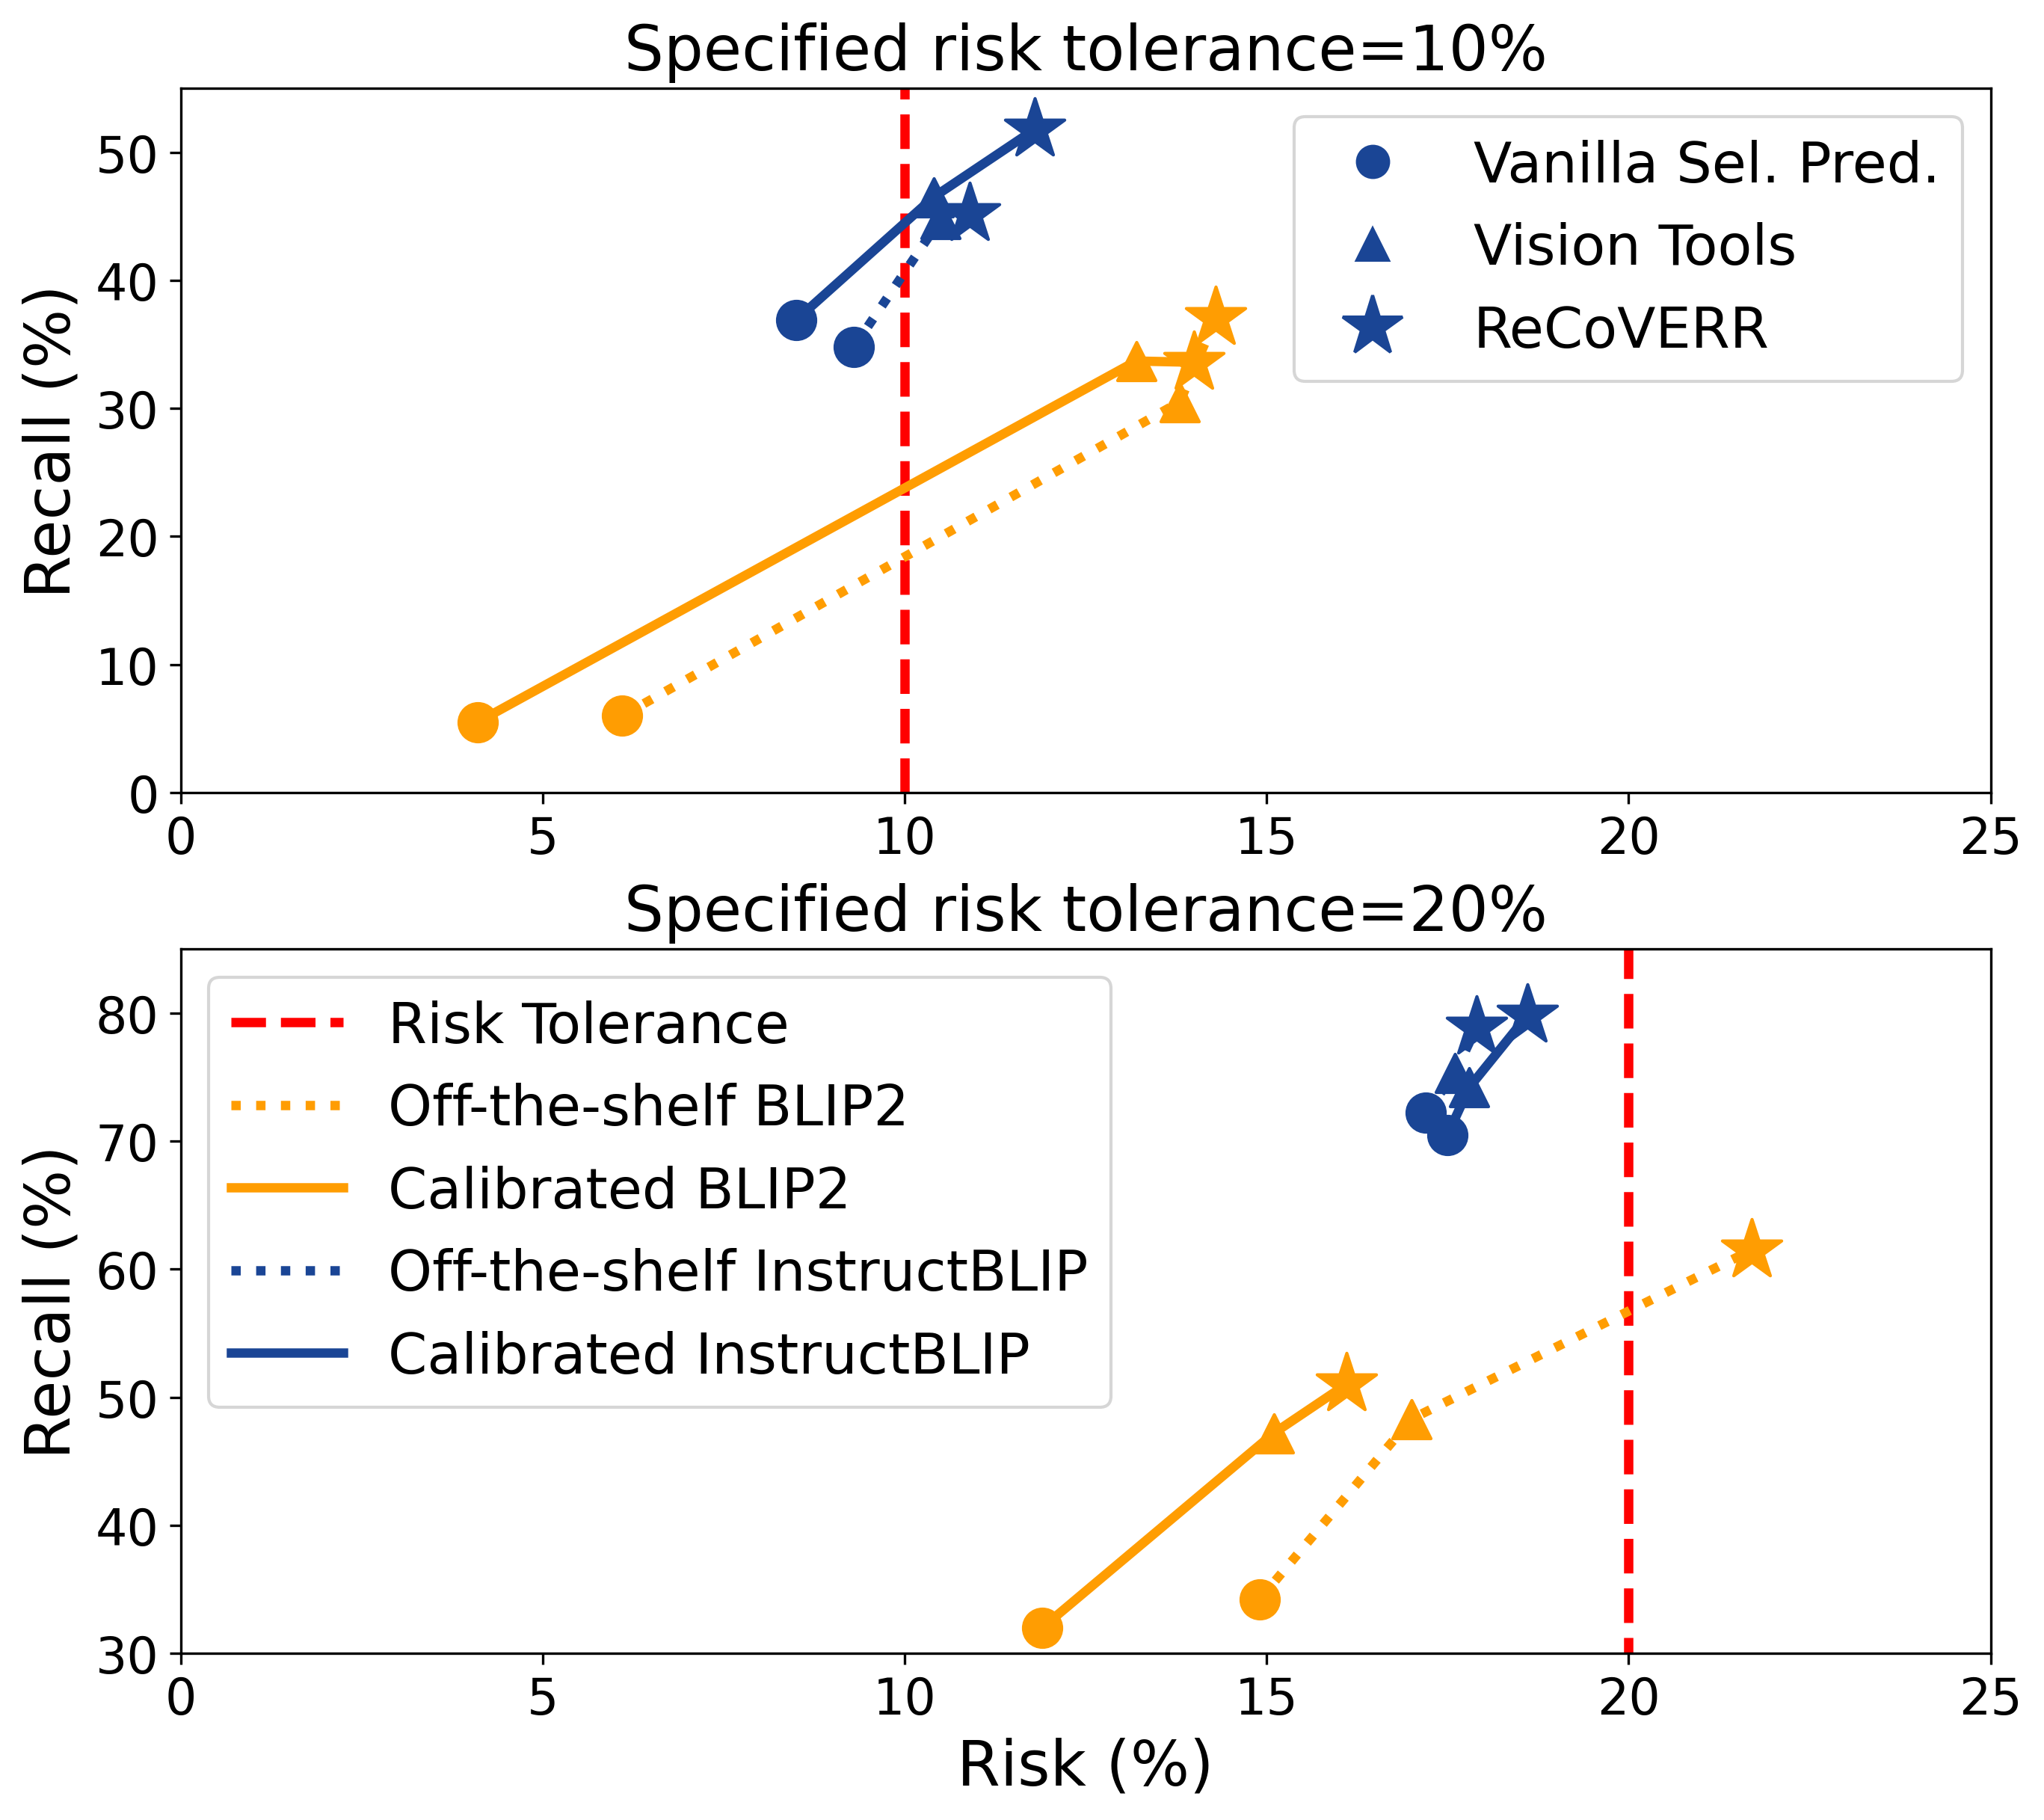

In [182]:
import json
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.lines as mlines

plt.size = (20, 25)
fig, (ax1, ax2) = plt.subplots(2, 1,  constrained_layout=True)
fig.set_size_inches(9, 8)
markers = ['o', '^', '*']
markersizes = [150, 150, 400]

ax1.plot(
    [10, 10], 
    [0, 55], 
    linestyle='--',
    linewidth=3,
    label=f"Risk Tolerance",
    color='r')

# Calibrated BLIP2

recall_risk_data = [
    [[6, 30.5, 37.1], [6.1, 13.8, 14.3]],
    [[5.5, 33.7, 33.6], [4.1, 13.2, 14]],
    [[34.8, 44.8, 45.2], [9.3, 10.5, 10.9]],
    [[36.9, 46.5, 51.8], [8.5, 10.4, 11.8]]
]
model_names = ["Off-the-shelf BLIP2", "Calibrated BLIP2", "Off-the-shelf InstructBLIP", "Calibrated InstructBLIP"]
linestyles = ['dotted', 'solid', 'dotted', 'solid']
colors = ['#ff9d02', '#ff9d02', '#1a4595', '#1a4595']

for i in range(4):
    data = recall_risk_data[i]
    ax1.plot(
        data[1], 
        data[0], 
        label=model_names[i],
        linewidth=3,
        linestyle=linestyles[i],
        color=colors[i])
    for j, (x, y) in enumerate(zip(data[0], data[1])):
        ax1.scatter(y, x, marker=markers[j], s=markersizes[j], color=colors[i])


#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Specified risk tolerance=10%', fontsize=20)
ax1.set_yticks(ticks=[i*10 for i in range(6)])
ax1.set_xticks(ticks=[i*5 for i in range(6)])
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylim(0, 55)
ax1.set_xlim(0, 25)
ax1.set_ylabel('Recall (%)', fontsize=20)
#ax1.set_xlabel('Risk (%)', fontsize=20)
#ax1.legend(loc='lower right', fontsize=14)

vanilla = mlines.Line2D([], [], color='#1a4595', marker='o', linestyle='None',
                          markersize=10, label='Vanilla Sel. Pred.')
vision_tools = mlines.Line2D([], [], color='#1a4595', marker='^', linestyle='None',
                          markersize=10, label='Vision Tools')
recoverr = mlines.Line2D([], [], color='#1a4595', marker='*', linestyle='None',
                          markersize=20, label='ReCoVERR')
ax1.legend(handles=[vanilla, vision_tools, recoverr], loc='upper right', fontsize=18)

ax2.plot(
    [20, 20], 
    [0, 100], 
    linestyle='--',
    linewidth=3,
    label=f"Risk Tolerance",
    color='r')

# Calibrated BLIP2

recall_risk_data = [
    [[34.2, 48.3, 61.5], [14.9, 17, 21.7]],
    [[32, 47.2, 51], [11.9, 15.1, 16.1]],
    [[72.2, 75.3, 78.9], [17.2, 17.6, 17.9]],
    [[70.5, 74.2, 79.8], [17.5, 17.8, 18.6]]
]
model_names = ["Off-the-shelf BLIP2", "Calibrated BLIP2", "Off-the-shelf InstructBLIP", "Calibrated InstructBLIP"]
linestyles = ['dotted', 'solid', 'dotted', 'solid']
colors = ['#ff9d02', '#ff9d02', '#1a4595', '#1a4595']

for i in range(4):
    data = recall_risk_data[i]
    ax2.plot(
        data[1], 
        data[0], 
        label=model_names[i],
        linewidth=3,
        linestyle=linestyles[i],
        color=colors[i])
    for j, (x, y) in enumerate(zip(data[0], data[1])):
        ax2.scatter(y, x, marker=markers[j], s=markersizes[j], color=colors[i])
        #ax1.scatter(x, y, marker=markers[j], s=150, facecolors='white', edgecolors=colors[i], alpha=1)


#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax2.set_title(f'Specified risk tolerance=20%', fontsize=20)
ax2.set_yticks(ticks=[i*10 for i in range(11)])
ax2.set_xticks(ticks=[i*5 for i in range(6)])
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_ylim(30, 85)
ax2.set_xlim(0, 25)
ax2.set_ylabel('Recall (%)', fontsize=20)
ax2.set_xlabel('Risk (%)', fontsize=20)
ax2.legend(loc='upper left', fontsize=18)

plt.show()
